# Egg-box Likelihood with Uniform Prior

This is a toy model shows how Nested Sampling easily handles likelihoods with multimodal behaviour.

$L(x) = P(y | x) = 5 (2. + \prod_i cos(\frac{\theta_i}{2})))$

and

$P(x) = \mathcal{U}[x \mid 0, 10 \pi]$.

## Overview

We'll cover the following topics:

1. How to handle multimodal behaviour with JAXNS.
2. How to use the `prior_chain` outside the nested sampler, e.g. to sample/plot.
3. How to brute-force compute the evidence for comparison.

In [7]:

from jaxns.nested_sampler.nested_sampling import NestedSampler
from jaxns.prior_transforms import PriorChain, UniformPrior
from jaxns.utils import summary, analytic_log_evidence
from jaxns.internals.maps import prepare_func_args
from jaxns.plotting import plot_cornerplot, plot_diagnostics
from jax import random, jit, vmap
from jax import numpy as jnp
import pylab as plt

In [8]:
def log_likelihood(theta):
    return 5. * (2. + jnp.prod(jnp.cos(0.5 * theta)))


ndim = 2
with PriorChain() as prior_chain:
    UniformPrior('theta', low=jnp.zeros(ndim), high=jnp.pi * 10. * jnp.ones(ndim))

log_Z_true = analytic_log_evidence(prior_chain=prior_chain, log_likelihood=log_likelihood, S=250)
print(f"True log(Z)={log_Z_true}")

True log(Z)=12.401799700614417


WARNING[2022-03-03 02:00:02,580]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.


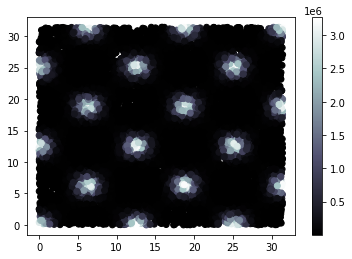

In [13]:
# To use the prior_chain to sample from, e.g. for plotting, we should first build it. This typically gets done inside the nested sampler, and if not should be done manually.
prior_chain.build()

theta = vmap(lambda key: prior_chain(prior_chain.sample_U_flat(key)))(
    random.split(random.PRNGKey(0), 10000))
# The `prepare_func_args(log_likelihood)` turns the log_likelihood into a function that nicely accepts **kwargs
lik = vmap(lambda theta: prepare_func_args(log_likelihood)(**theta))(theta)
sc = plt.scatter(theta['theta'][:, 0], theta['theta'][:, 1], c=jnp.exp(lik), cmap='bone')
plt.colorbar(sc)
plt.show()

In [10]:
# Create the nested sampler class. In this case without any tuning.
ns = NestedSampler(log_likelihood, prior_chain)
# We jit-compile
ns = jit(ns)
# We run, with any parameters desired. In this case, without any tuning.
results = ns(random.PRNGKey(4525325))


WARNING[2022-03-03 01:50:58,594]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.


In [11]:
# We can use the summary utility to display results
summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 32647
# samples: 855
# likelihood evals / sample: 38.2
--------
logZ=12.39 +- 0.12
H=6.6
ESS=212
--------
theta[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
theta[0]: 15.2 +- 9.3 | 2.5 / 15.7 / 28.7 | 30.3 | 18.8
theta[1]: 15.5 +- 8.7 | 5.0 / 15.6 / 29.1 | 6.6 | 18.8
--------


'--------\nTermination Conditions:\nSmall remaining evidence\n--------\n# likelihood evals: 32647\n# samples: 855\n# likelihood evals / sample: 38.2\n--------\nlogZ=12.39 +- 0.12\nH=6.6\nESS=212\n--------\ntheta[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\ntheta[0]: 15.2 +- 9.3 | 2.5 / 15.7 / 28.7 | 30.3 | 18.8\ntheta[1]: 15.5 +- 8.7 | 5.0 / 15.6 / 29.1 | 6.6 | 18.8\n--------'

WARNING[2022-03-03 01:51:23,787]: No handles with labels found to put in legend.


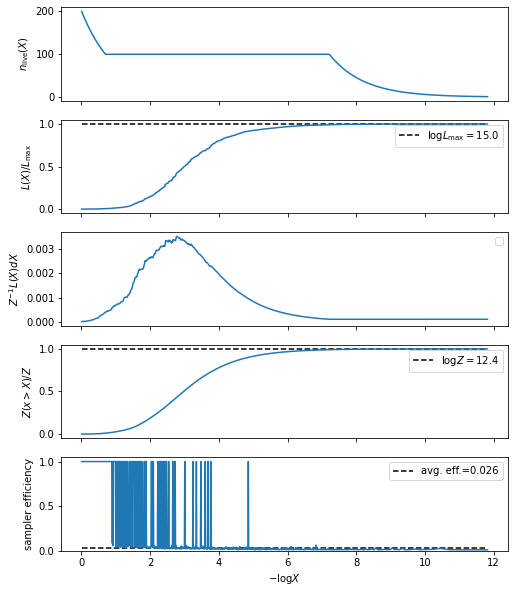

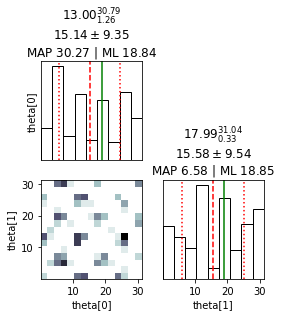

In [12]:
# We plot useful diagnostics and a distribution cornerplot
plot_diagnostics(results)
plot_cornerplot(results)